In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

# Fixed value to consistence
tf.random.set_seed(1337)

# Check if there's any GPU available
print("GPUs: ", len(tf.config.list_physical_devices('GPU')))
#      \/ Sad AMD gpu sounds

GPUs:  0


In [2]:
# Function to reduce the length of the dataset
def reduceDataset(x_data, y_data, percent):
    # Calculate the amount of samples to choose from
    num_samples = int(len(x_data) * (percent / 100))
    
    # Generates X% of indices randomly
    indices = np.random.choice(len(x_data), num_samples, replace=False)
    
    # Filter the data using the random indices
    x_reduced = x_data[indices]
    y_reduced = y_data[indices]
    
    return x_reduced, y_reduced

# Load MNIST database
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reduces train/test by X percent
percent = 100
x_train, y_train = reduceDataset(x_train, y_train, percent)
x_test, y_test = reduceDataset(x_test, y_test, percent)

# Print to check size
print(f"Database used: {percent}%")
print(f"Train size: {x_train.shape}")
print(f"Test size: {x_test.shape}")

Database used: 100%
Train size: (60000, 28, 28)
Test size: (10000, 28, 28)


In [3]:
# Merge both datasets (train/test)
dataset = np.concatenate([x_train, x_test], axis=0)

# Normalize the images from [0,255] to [0,1]
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

In [4]:
BATCH_SIZE = 64

# Reshaping the data
# CNN layers requires 3 channels
dataset = np.reshape(dataset, (-1, 28, 28, 1))
# Create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# BATCH_SIZE images per batch instead of 1
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

In [5]:
# The generator typically uses LeakyReLU, discriminator uses ReLU

# Input noise vector for the generator
NOISE_DIM = 150

# Build generator model with upsampling layers
generator = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
    layers.Dense(7 * 7 * 256),
    layers.Reshape(target_shape=(7, 7, 256)),
    layers.Conv2DTranspose(256, 3, activation=None, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU layer
    layers.Conv2DTranspose(128, 3, activation=None, strides=2, padding="same"),
    layers.BatchNormalization(),
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU layer
    layers.Conv2DTranspose(1, 3, activation="tanh", padding="same")
])

generator.summary()

C:\Users\gusta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
C:\Users\gusta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,894,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,153 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,781,953 (10.61 MB)

 Trainable params: 2,781,185 (10.61 MB)

 Non-trainable params: 768 (3.00 KB)

In [6]:
# design a discriminator with downsampling layers
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 256)         │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │         401,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 699,137 (2.67 MB)

 Trainable params: 699,137 (2.67 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Choose different learning rate values to balance the system
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5) # Generator
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5) # Discriminator

# Binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# Accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

In [8]:
@tf.function
def trainDStep(data):
  # Batch is (32, 28, 28, 1), so extract 32 value
  batchSize = tf.shape(data)[0]
    
  # Create a noise vector as generator input sampled from Gaussian Random Normal
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  # Concatenate real/fake labels
  y_true = tf.concat([
      tf.ones(batchSize, 1), # Original data is real
      tf.zeros(batchSize, 1) # Forged data is fake
    ], axis=0)

  # Record the calculated gradients
  with tf.GradientTape() as tape:
    # Generate forged samples
    fake = generator(noise)
    # Concatenate real and forged data
    x = tf.concat([data, fake], axis=0)
    # See if the discriminator detects them
    y_pred = discriminator(x)
    # Calculate the loss
    discriminatorLoss = lossFn(y_true, y_pred)

  # Apply the backward path and update weights
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # Report accuracy
  dAccMetric.update_state(y_true, y_pred)

  # Return the loss
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
    }

In [9]:
@tf.function
# Function to train the generator in a single step
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  y_true = tf.ones(batchSize, 1)

  # Track operations to compute gradients for generator's loss
  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  # Return generator loss and accuracy after training step
  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

In [10]:
from matplotlib import pyplot as plt

# Function to plot images between steps
def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r", vmin=0, vmax=1)  # Adjust vmin/vmax if needed
        plt.axis('off')

    plt.gcf().patch.set_facecolor('black')  # Set figure background to black
    plt.show();

C:\Users\gusta\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\backend\tensorflow\nn.py:681: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Epoch: 0
Generator Loss: 3.0116
Discriminator Loss: 0.1106
Generator Accuracy: 9.12%
Discriminator Accuracy: 93.93%


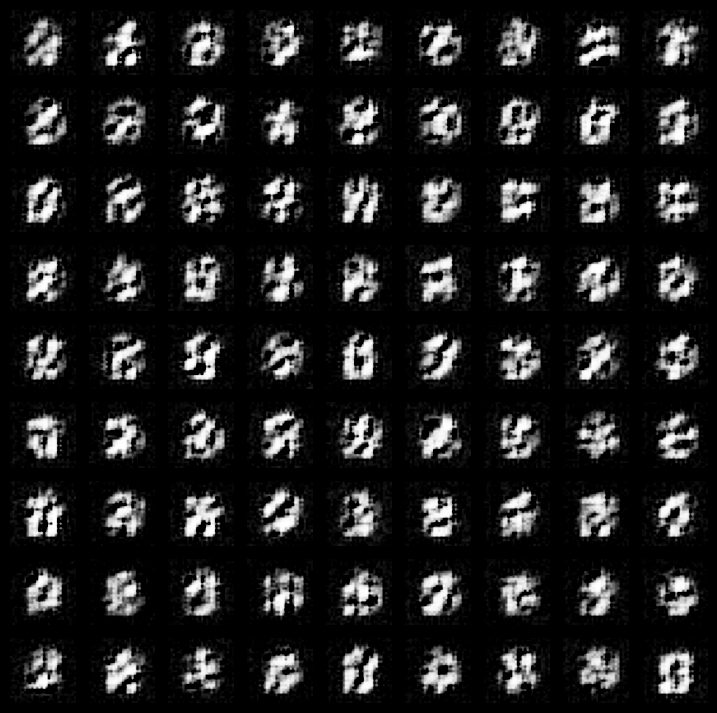

Epoch: 1
Generator Loss: 3.8317
Discriminator Loss: 0.0396
Generator Accuracy: 1.77%
Discriminator Accuracy: 98.55%
Epoch: 2
Generator Loss: 2.9562
Discriminator Loss: 0.1074
Generator Accuracy: 1.16%
Discriminator Accuracy: 98.86%


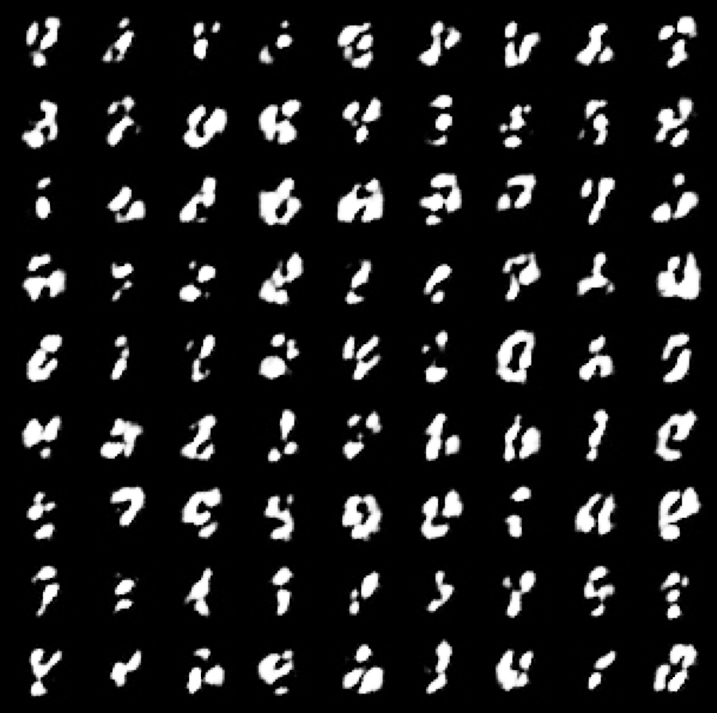

Epoch: 3
Generator Loss: 2.6508
Discriminator Loss: 0.1485
Generator Accuracy: 1.09%
Discriminator Accuracy: 98.38%
Epoch: 4
Generator Loss: 2.6567
Discriminator Loss: 0.1530
Generator Accuracy: 1.14%
Discriminator Accuracy: 97.92%


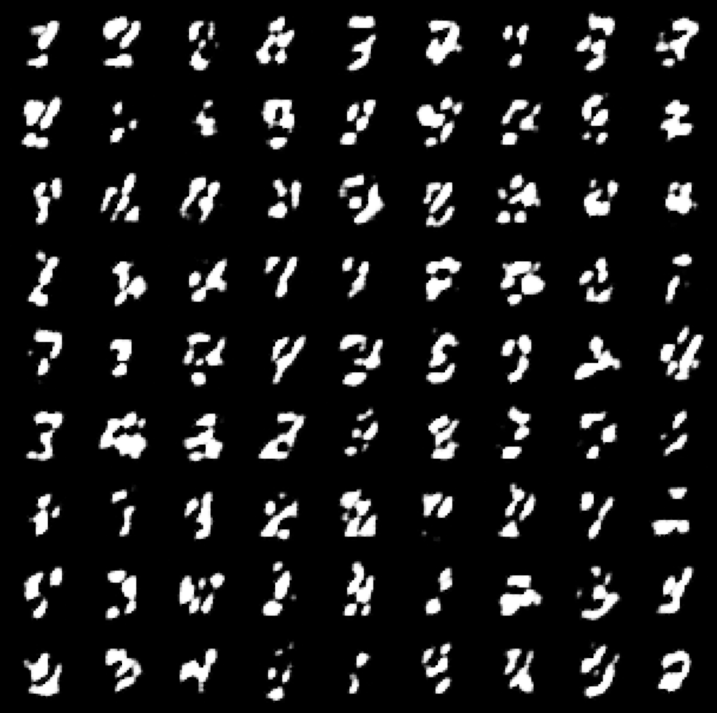

Epoch: 5
Generator Loss: 2.8491
Discriminator Loss: 0.1404
Generator Accuracy: 1.20%
Discriminator Accuracy: 97.61%
Epoch: 6
Generator Loss: 3.0895
Discriminator Loss: 0.1231
Generator Accuracy: 1.23%
Discriminator Accuracy: 97.42%


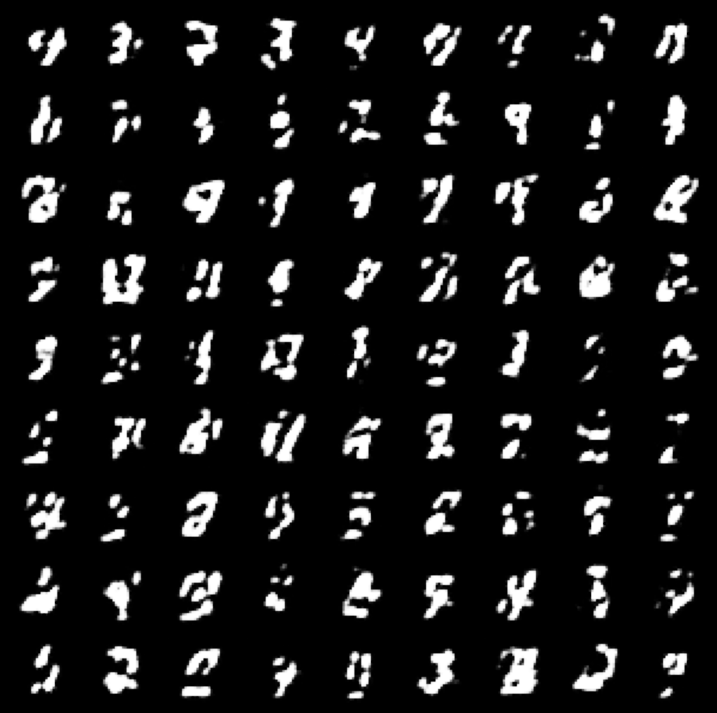

Epoch: 7
Generator Loss: 3.3413
Discriminator Loss: 0.1109
Generator Accuracy: 1.23%
Discriminator Accuracy: 97.34%
Epoch: 8
Generator Loss: 3.4966
Discriminator Loss: 0.1033
Generator Accuracy: 1.23%
Discriminator Accuracy: 97.31%


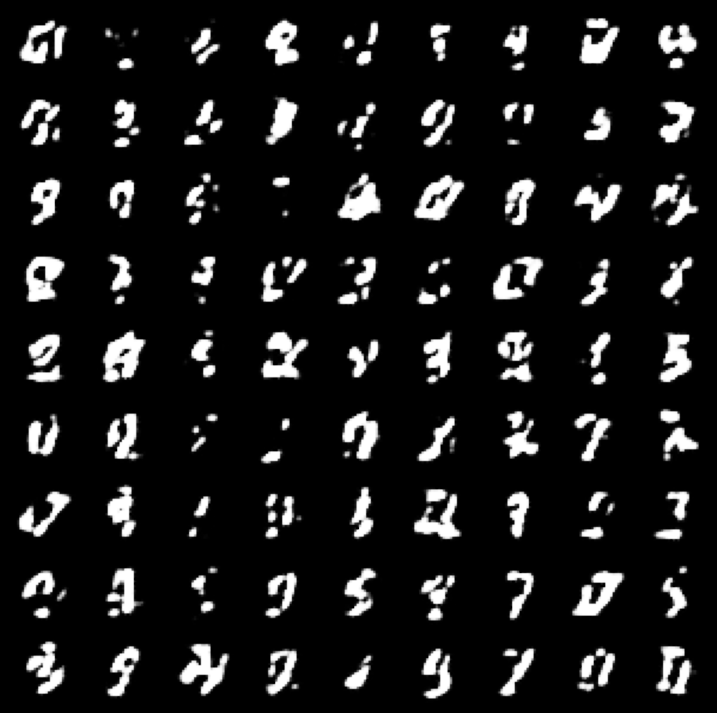

Epoch: 9
Generator Loss: 3.6345
Discriminator Loss: 0.0966
Generator Accuracy: 1.22%
Discriminator Accuracy: 97.29%
Epoch: 10
Generator Loss: 3.7493
Discriminator Loss: 0.0902
Generator Accuracy: 1.19%
Discriminator Accuracy: 97.30%


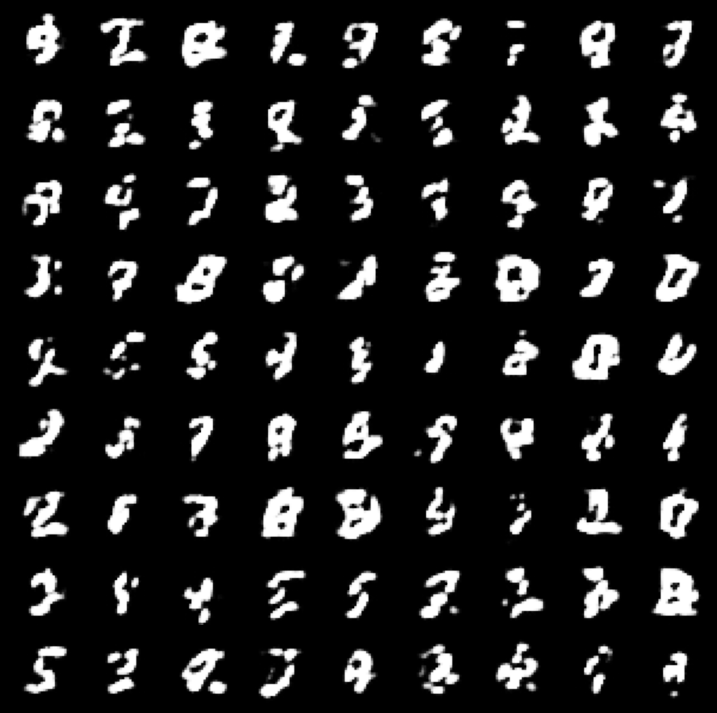

Epoch: 11
Generator Loss: 3.8753
Discriminator Loss: 0.0813
Generator Accuracy: 1.16%
Discriminator Accuracy: 97.32%
Epoch: 12
Generator Loss: 4.0122
Discriminator Loss: 0.0764
Generator Accuracy: 1.13%
Discriminator Accuracy: 97.36%


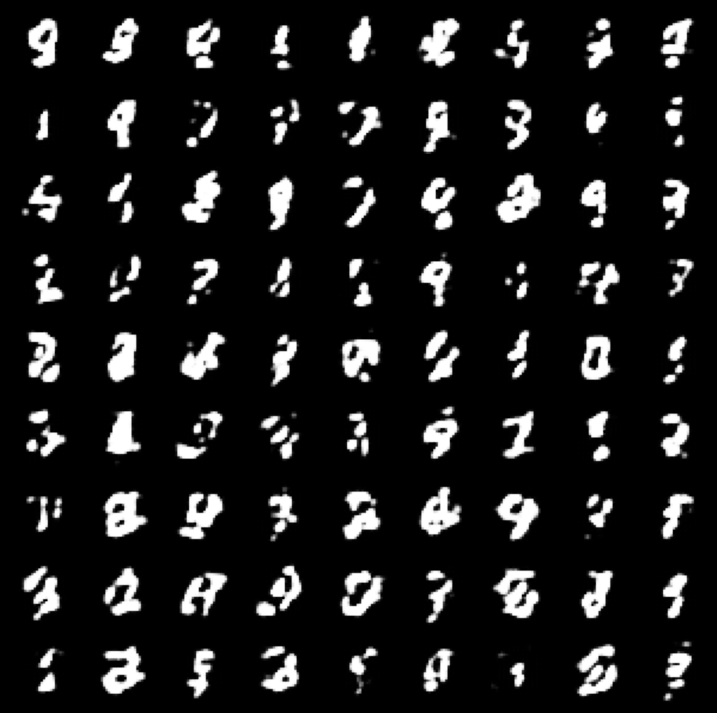

Epoch: 13
Generator Loss: 4.1305
Discriminator Loss: 0.0682
Generator Accuracy: 1.09%
Discriminator Accuracy: 97.41%
Epoch: 14
Generator Loss: 4.2699
Discriminator Loss: 0.0655
Generator Accuracy: 1.05%
Discriminator Accuracy: 97.46%


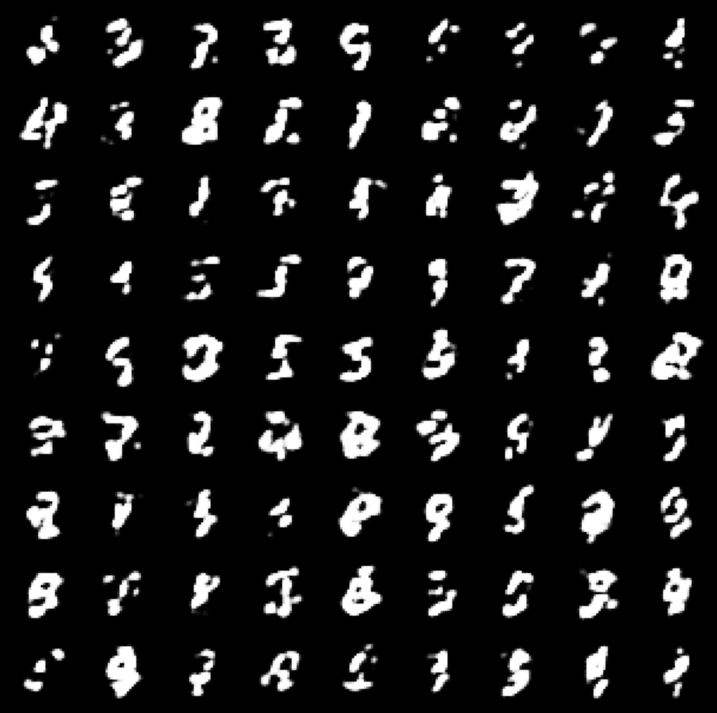

Epoch: 15
Generator Loss: 4.4100
Discriminator Loss: 0.0604
Generator Accuracy: 1.01%
Discriminator Accuracy: 97.51%
Epoch: 16
Generator Loss: 4.5311
Discriminator Loss: 0.0573
Generator Accuracy: 0.98%
Discriminator Accuracy: 97.56%


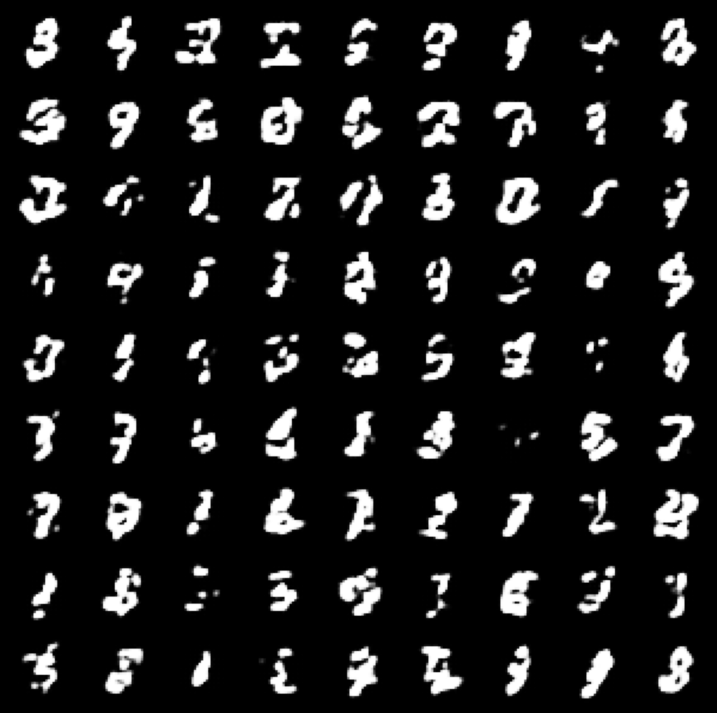

Epoch: 17
Generator Loss: 4.6563
Discriminator Loss: 0.0535
Generator Accuracy: 0.94%
Discriminator Accuracy: 97.61%
Epoch: 18
Generator Loss: 4.8008
Discriminator Loss: 0.0509
Generator Accuracy: 0.90%
Discriminator Accuracy: 97.66%


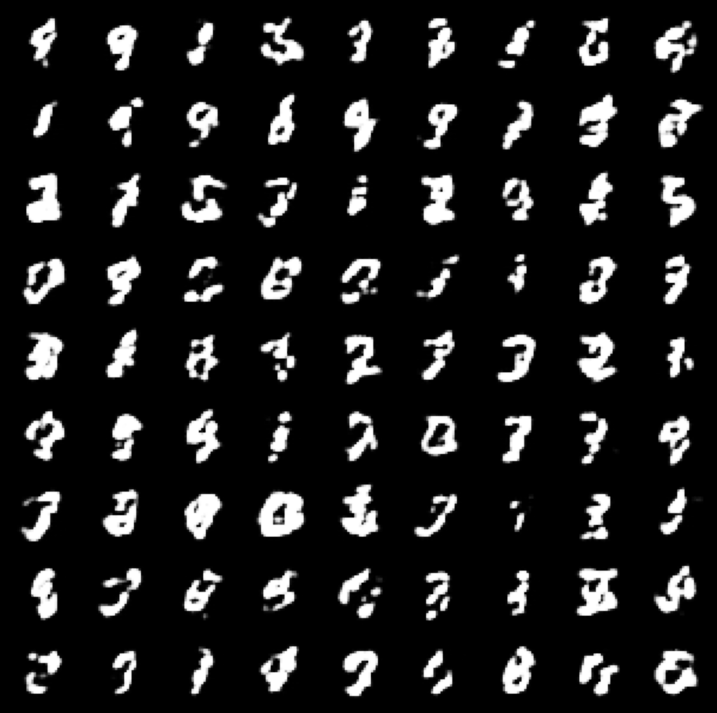

Epoch: 19
Generator Loss: 4.8671
Discriminator Loss: 0.0515
Generator Accuracy: 0.87%
Discriminator Accuracy: 97.71%
Epoch: 20
Generator Loss: 4.9373
Discriminator Loss: 0.0452
Generator Accuracy: 0.85%
Discriminator Accuracy: 97.75%


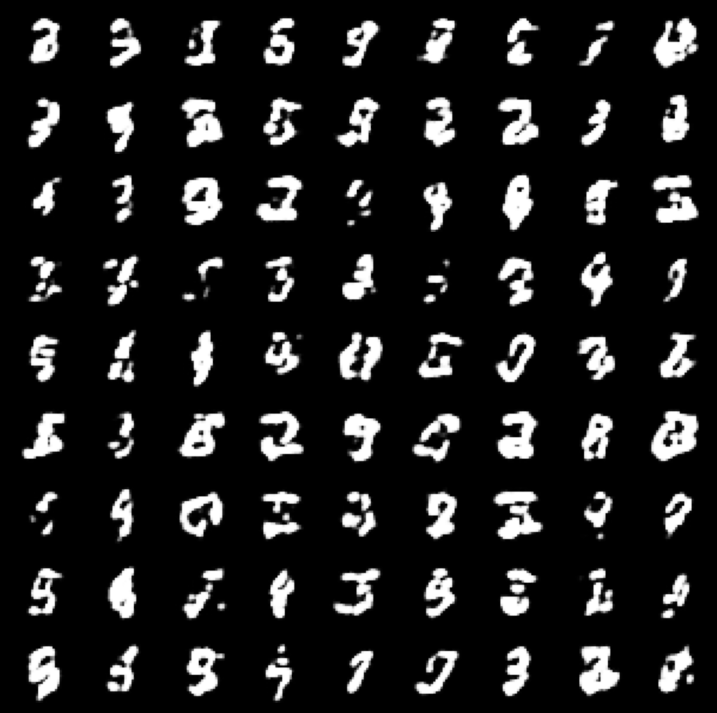

Epoch: 21
Generator Loss: 5.0303
Discriminator Loss: 0.0441
Generator Accuracy: 0.82%
Discriminator Accuracy: 97.80%
Epoch: 22
Generator Loss: 5.0820
Discriminator Loss: 0.0437
Generator Accuracy: 0.79%
Discriminator Accuracy: 97.85%


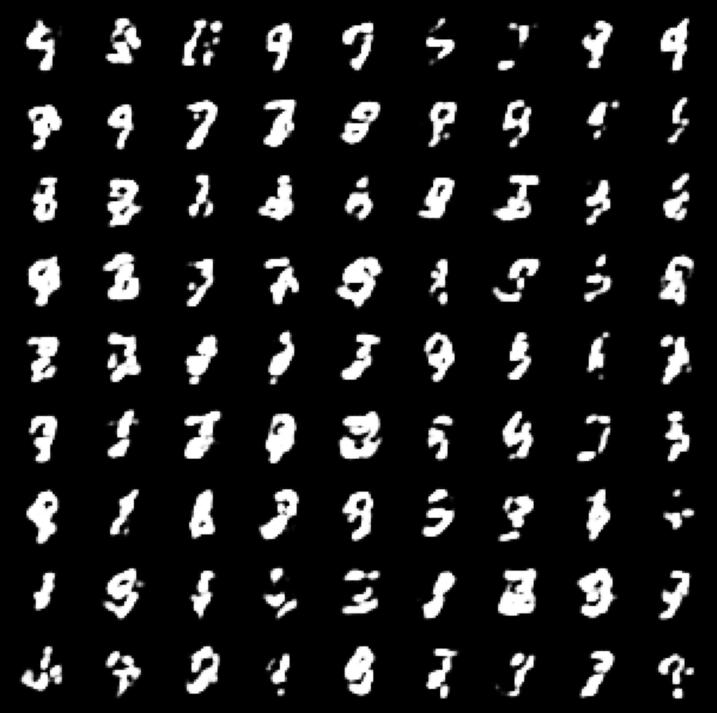

Epoch: 23
Generator Loss: 5.1988
Discriminator Loss: 0.0401
Generator Accuracy: 0.77%
Discriminator Accuracy: 97.89%
Epoch: 24
Generator Loss: 5.2683
Discriminator Loss: 0.0399
Generator Accuracy: 0.75%
Discriminator Accuracy: 97.93%


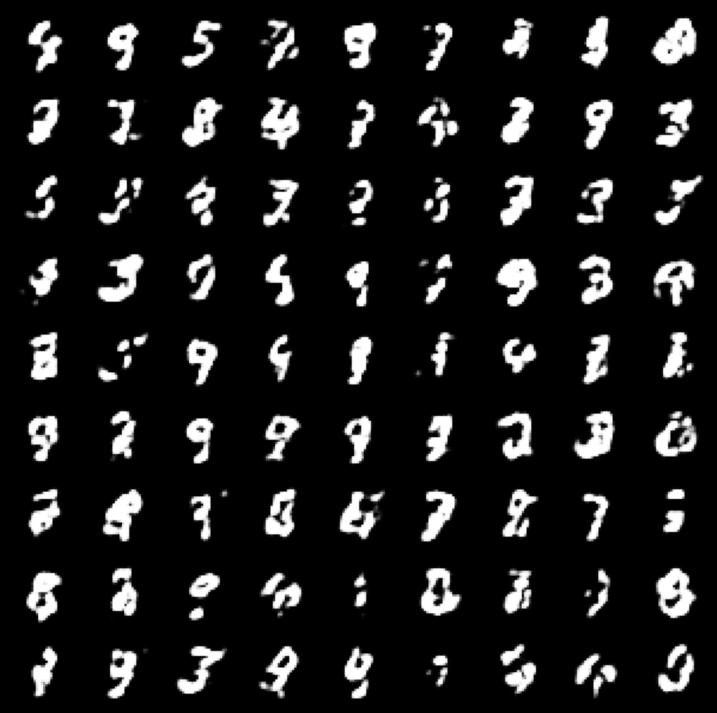

Epoch: 25
Generator Loss: 5.3940
Discriminator Loss: 0.0387
Generator Accuracy: 0.73%
Discriminator Accuracy: 97.97%
Epoch: 26
Generator Loss: 5.4349
Discriminator Loss: 0.0374
Generator Accuracy: 0.70%
Discriminator Accuracy: 98.00%


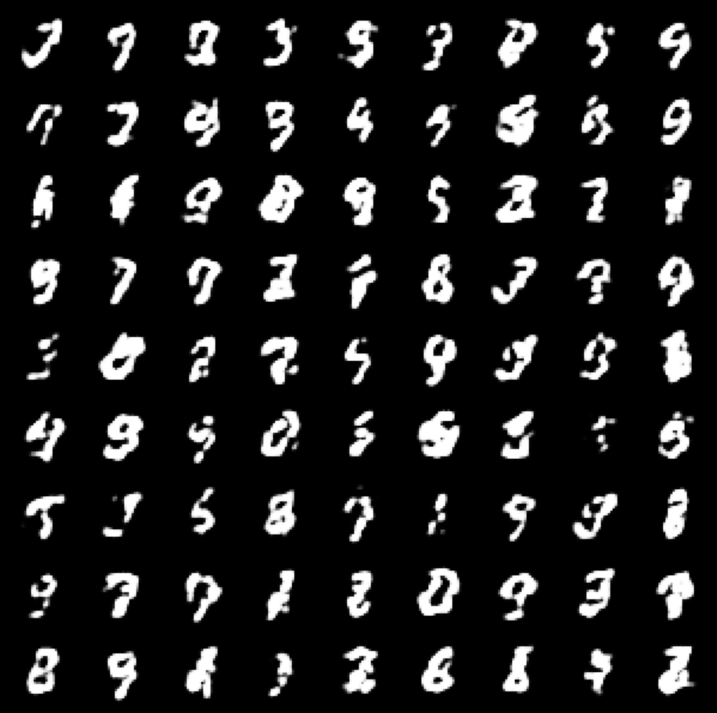

Epoch: 27
Generator Loss: 5.4348
Discriminator Loss: 0.0354
Generator Accuracy: 0.68%
Discriminator Accuracy: 98.04%
Epoch: 28
Generator Loss: 5.4781
Discriminator Loss: 0.0389
Generator Accuracy: 0.66%
Discriminator Accuracy: 98.07%


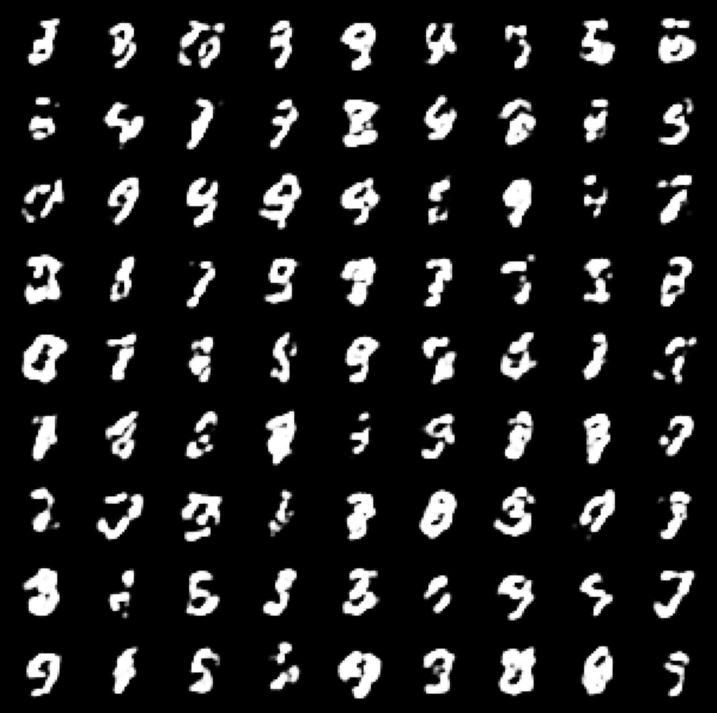

Epoch: 29
Generator Loss: 5.5968
Discriminator Loss: 0.0327
Generator Accuracy: 0.65%
Discriminator Accuracy: 98.10%
Epoch: 30
Generator Loss: 5.6243
Discriminator Loss: 0.0387
Generator Accuracy: 0.63%
Discriminator Accuracy: 98.13%


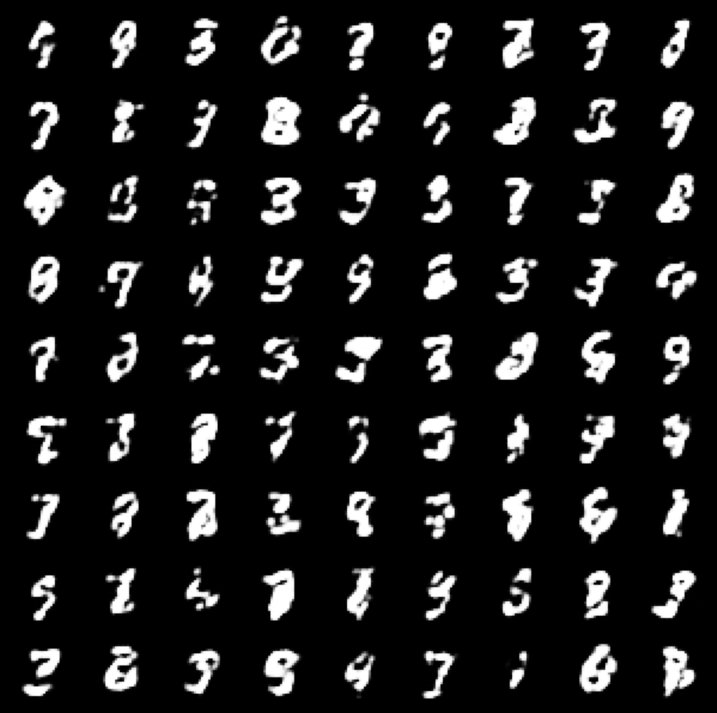

Epoch: 31
Generator Loss: 5.6848
Discriminator Loss: 0.0324
Generator Accuracy: 0.62%
Discriminator Accuracy: 98.16%
Epoch: 32
Generator Loss: 5.6962
Discriminator Loss: 0.0318
Generator Accuracy: 0.60%
Discriminator Accuracy: 98.19%


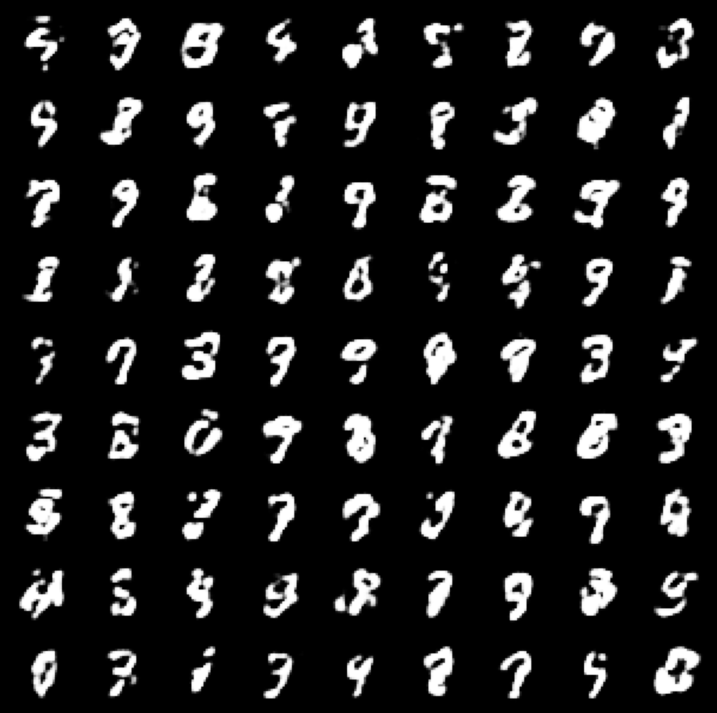

Epoch: 33
Generator Loss: 5.9514
Discriminator Loss: 0.0337
Generator Accuracy: 0.59%
Discriminator Accuracy: 98.21%
Epoch: 34
Generator Loss: 5.8869
Discriminator Loss: 0.0319
Generator Accuracy: 0.57%
Discriminator Accuracy: 98.24%


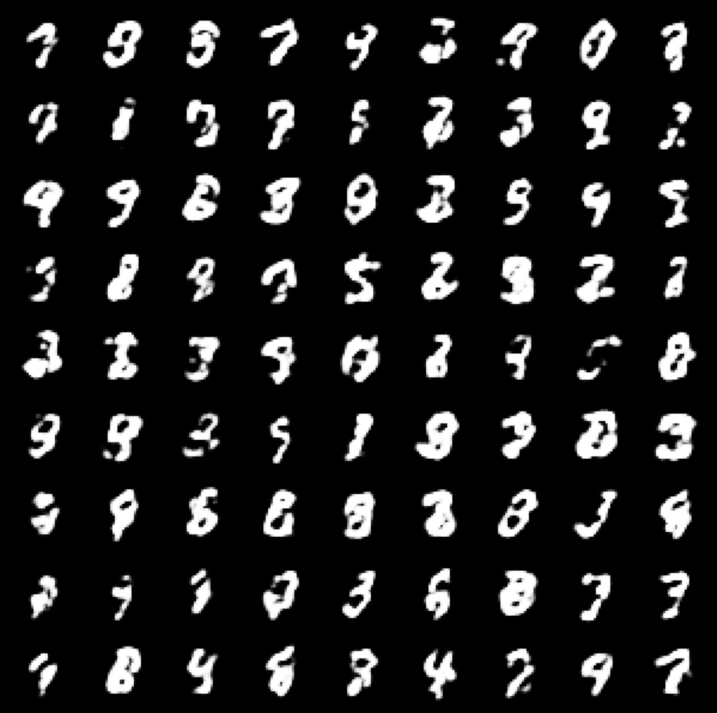

Epoch: 35
Generator Loss: 5.8797
Discriminator Loss: 0.0291
Generator Accuracy: 0.56%
Discriminator Accuracy: 98.26%
Epoch: 36
Generator Loss: 6.0333
Discriminator Loss: 0.0315
Generator Accuracy: 0.55%
Discriminator Accuracy: 98.29%


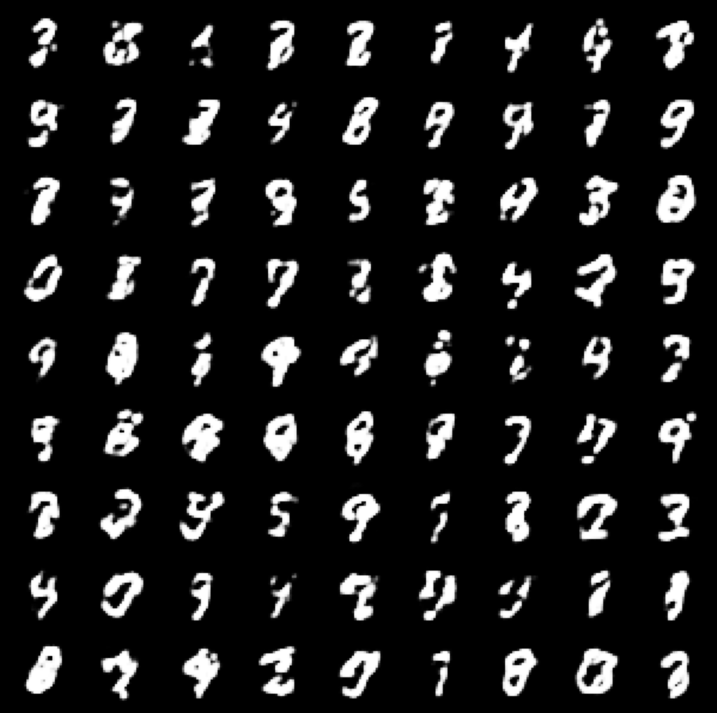

Epoch: 37
Generator Loss: 5.9966
Discriminator Loss: 0.0283
Generator Accuracy: 0.54%
Discriminator Accuracy: 98.31%
Epoch: 38
Generator Loss: 6.0317
Discriminator Loss: 0.0294
Generator Accuracy: 0.52%
Discriminator Accuracy: 98.33%


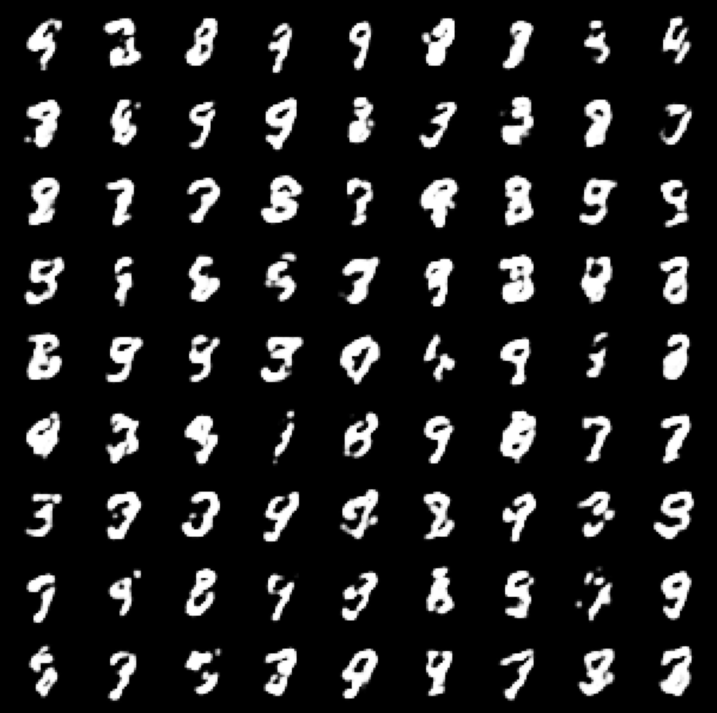

Epoch: 39
Generator Loss: 6.1881
Discriminator Loss: 0.0262
Generator Accuracy: 0.51%
Discriminator Accuracy: 98.36%


In [11]:
for epoch in range(40):

  # Accumulate the loss to calculate the average
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  # Loop the dataset one batch at a time
  for batch in dataset:

    # Train the discriminator
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # Train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    # Counter +1
    cnt += 1

  # Log the performance of generator and discriminator
  print("Epoch: {}\nGenerator Loss: {:0.4f}\nDiscriminator Loss: {:0.4f}\nGenerator Accuracy: {:0.2f}%\nDiscriminator Accuracy: {:0.2f}%".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))

  # Reduces plot spam
  if epoch % 2 == 0:
    plotImages(generator)

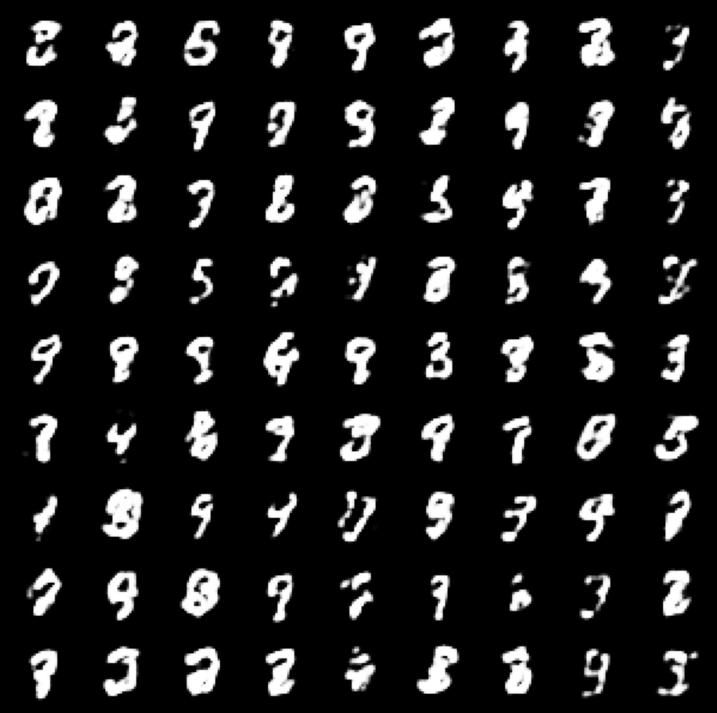

In [12]:
# Generate some images with the trained model
images = generator(np.random.normal(size=(81, NOISE_DIM)))

# Plot the generated samples
plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r", vmin=0, vmax=1)  # Adjust vmin/vmax if needed
    plt.axis('off')

plt.gcf().patch.set_facecolor('black')  # Set figure background to black
plt.show();